# Sandbox
For testing and developing new Cyber Security Assessment tools in an interactive and persistent development environment.

In [1]:
import itertools
import json
import copy
import random
import warnings
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats.distributions as distr
import seaborn as sns
import pandapower
from pathlib import Path as p

from cyber.assets import Defence, Vulnerability, CommmonDefences, CyberDevice
from communication.graph import CommNode, CommEdge
from communication.network import Aggregator, Device, CommNetwork
from attackers.random_attacker import RandomAttacker
from cyber.criticality import criticality_by_degree, criticality_by_power_flow, criticality_by_capacity
from cyber.analysis import Analyzer
from visualization.network import plot_communication_network
from visualization.grid import plot_physical_grid

## Procedural Generation
### Abstract Tree
Consists of Devices and Aggregators. 
* Aggregators (internal nodes) require a **Hard** amount of effort to compromise and have a 50% chance of being compromised if the necessary effort is spent
* Devices (leaf nodes) require an **Easy** amount of effort to compromise and also have a 50% chance of being compromised if the necesssary effort is spent
* Control Center (root node) is **Very Hard** to compromise

Controllable parameters include:
* Number of devices (leaf nodes)
* Number of Entrypoints (points where cyberattacks can originate)
* Number of children per parent node (inversely proportional to redundancy)
* Random deviation in number of children
* Sibling to Sibling communication (lateral edges between nodes on the same level)

In [3]:
seed = 42 # np.random.randint(low=0, high=52600)
np.random.seed(seed); random.seed(seed)
print(f"Seed: {np.random.get_state()[1][0]}")

with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", category=FutureWarning)
    grid=pandapower.networks.create_cigre_network_mv(with_der="all")
    pandapower.runpp(grid, algorithm="nr", calculate_voltage_angles=True, init="dc", trafo_model="t", trafo_loading="power",
                enforce_q_lims=True, voltage_depend_loads=True, numba=False, consider_line_temperature=False)
    print(grid)
    # criticality, lowest, highest = criticality_by_capacity(grid, verbose=False)
    # Specifications: "Default_specifications.json", "SmartMeter_specifications.json", "SCADA_specifications.json", ...
    #                 "WAMS_specifications.json", "Protection_specifications.json"
    spec_path = p.cwd() / "specifications" / "Default_specifications.json"
    network = CommNetwork(n_devices=3, n_entrypoints=1, children_per_parent=0, child_no_deviation=3, sibling_to_sibling_comm="all",
                    network_specs=spec_path, 
                    # criticality=criticality, crit_norm=False,
                    grid=grid, 
                    )
print(CommNetwork.show_tree(network.root))
print(f"Number of Components: {network.n_components}")

analyzer = Analyzer(network)
attacker = RandomAttacker(budget=52, verbose=False)

Seed: 42
This pandapower network includes the following parameter tables:
   - bus (15 element)
   - load (18 element)
   - sgen (13 element)
   - storage (2 element)
   - switch (8 element)
   - ext_grid (1 elements)
   - line (15 element)
   - trafo (2 element)
   - bus_geodata (15 element)
 and the following results tables:
   - res_bus (15 element)
   - res_line (15 element)
   - res_trafo (2 element)
   - res_ext_grid (1 elements)
   - res_load (18 element)
   - res_sgen (13 element)
   - res_storage (2 element)
   - res_switch (8 element)
Control Center(id=193, is_accessible=False)
   Aggregator(id=192, is_accessible=False)
      Aggregator(id=191, is_accessible=False)
         Aggregator(id=189, is_accessible=False)
            Aggregator(id=134, is_accessible=False)
               Aggregator(id=118, is_accessible=False)
                  Sensor Device(id=23, is_controller=False, is_autonomous=False, is_sensor=True, is_accessible=False)
                  Sensor Device(id=24, is_

## Visualization
Plot the structure of the communication network and physical grid (if present).

In [ ]:
plot_communication_network(network,
                        attacker=None, # Visualize compromise
                        palette="tab10", # "tab10" (default), "Set2", "Paired", "flare"
                        save_name="CommunicationNetwork", # input('Name of file'), # If provided, saves to media / SAVE_NAME.pdf 
                        figsize=(4,48),
                        show_legend=False, invert=True);


C:\Users\Xavier\AppData\Local\Temp\ipykernel_30404\3150580475.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


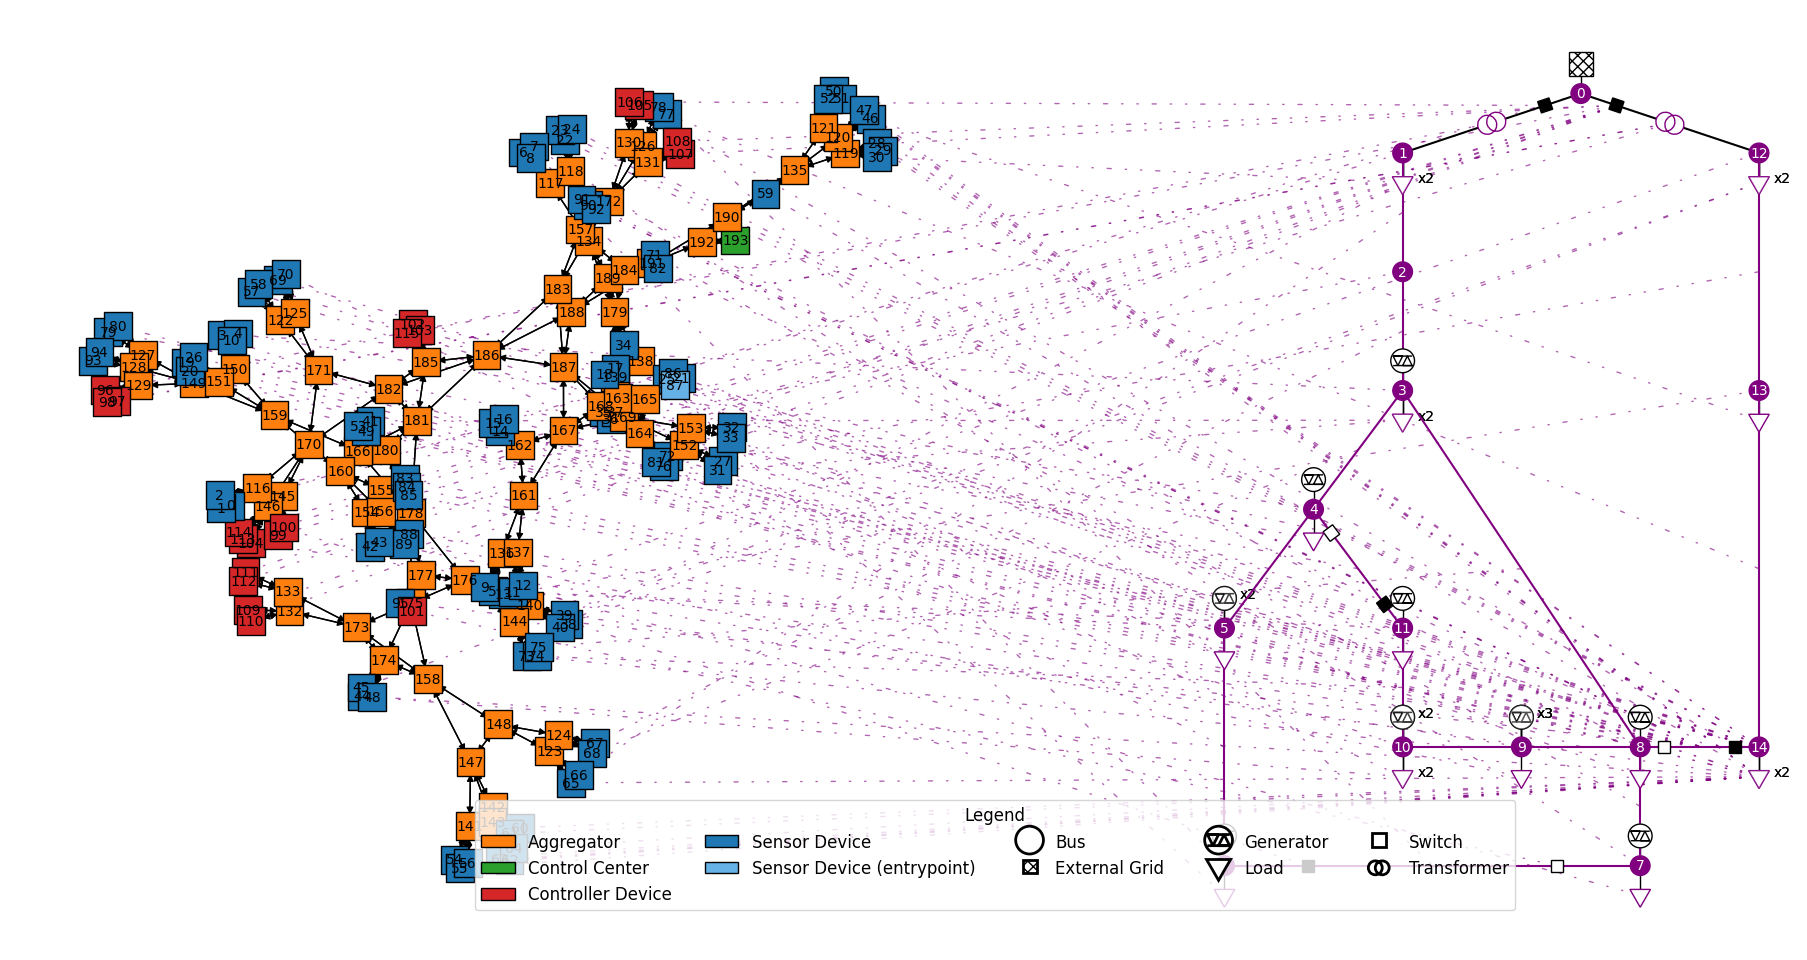

In [16]:
from matplotlib.patches import ConnectionPatch
from visualization.patches import ElectricalPatchHandler
from networkx.drawing.layout import spring_layout

if network.grid is not None:
    # for attempt_no in range(20):
    #     attacker.attack_network(network)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10)) # 16,20
    handles1, labels1, tree_pos = plot_communication_network(network, attacker=None, palette="tab10", save_name=None, ax=axes[0],
                                                             layout=spring_layout,
                                                             show=False, show_legend=False, invert=True) 
    handles2, labels2, coords = plot_physical_grid(network, size=0.2, distance=0.5, displace=False, ax=axes[1], show=False, show_legend=False)

    # Visualize connections between communication devices and physical equipment
    for device, pos in tree_pos.items():
        if isinstance(device, Device):
            kind, idx = device.equipment.kind, int(device.equipment.name)
            con = ConnectionPatch(xyA=coords[kind][idx], xyB=pos, coordsA="data", coordsB="data",
                                axesA=axes[1], axesB=axes[0], color="red" if device.is_compromised else "purple",
                                alpha=0.6, linestyle=(0, (3, 10, 1, 10, 1, 10)), lw=1, zorder=-10)
            axes[0].add_artist(con)

    # Combine the 2 legends
    handles = list(handles1) + list(handles2)
    labels = list(labels1) + list(labels2)
    ITEMS_PER_ROW = 5
    ncol = min(ITEMS_PER_ROW, len(labels))
    nrows = 1 + (len(labels) // ITEMS_PER_ROW)
    fig.legend(labels=labels, handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.01*nrows), ncol=ncol,
            handler_map={patch_maker:ElectricalPatchHandler() for patch_maker in handles2},
            title="Legend", fancybox=True, fontsize='large', title_fontsize='larger')
    plt.tight_layout()
    file_name = "CommunicationNetwork" # input('Name of file')
    fig.savefig(p.cwd() / "media" / f"{file_name}.pdf")
    fig.savefig(p.cwd() / "media" / f"{file_name}.png")
    plt.show()
    network.reset()
else:
     plot_communication_network(network,
                                attacker=None, # Visualize compromise
                                palette="tab10", # "tab10" (default), "Set2", "Paired", "flare"
                                save_name="Test", # input('Name of file'), # If provided, saves to media / SAVE_NAME.pdf 
                                figsize=(4,4),
                                show_legend=False, invert=False) 

In [ ]:
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, Colormap, Normalize, LogNorm

from visualization.grid import color_by_criticality, color_by_comm, add_buses, add_switches, add_transformers, add_symbol
from pathlib import Path
from collections import defaultdict

def color_by_criticality(network, kind, cmap="jet"):
    criticality = network.criticality[kind]
    lowest = min([np.min(array) for array in network.criticality.values() if len(array) > 0 and np.min(array) > 0])
    highest = max([np.max(array) for array in network.criticality.values() if len(array) > 0])
    norm = LogNorm(vmin=lowest, vmax=highest)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.colormaps[cmap])
    colors = sm.to_rgba(criticality)
    return list(colors)

_ = plot_physical_grid(network, size=0.2, distance=0.5, color_by="color_by_criticality",
                       save_name="Criticality_Capacity",
                       displace=False, show=True, show_legend=False, show_colorbar=True, figsize=(16,12))

### Electrical Grid
Visualize the electrical grid that the communication network is connected to.

In [ ]:
from visualization.patches import ElectricalPatchMaker

symbols = ["trafo", "ext_grid", "switch", "sgen", "load", "bus"]
nrows = len(symbols) // 2 + (1 if len(symbols) % 2 != 0 else 0)
ncols = min(2, 1 + (len(symbols) // 2))
fig, axes = plt.subplots(figsize=(ncols*5,nrows*5), sharex=True, sharey=True,
                         nrows=nrows, ncols=ncols)
for i, patch_maker in enumerate(symbols):
    pm = ElectricalPatchMaker(symbol=patch_maker, edgecolor="black", facecolor="None", lw=3)
    ax = axes[i] if nrows == 1 else axes[i // 2, i % 2]
    ax.add_patch(pm.patch)
    
    ax.plot([pm.centroid[0]], [pm.centroid[1]], marker="*", markersize=5, color="black", zorder=10)
    ax.set(xlim=(-2, 2), ylim=(-2, 2), title=patch_maker, xticks=[], yticks=[])
plt.show()

## Analysis

### Monte Carlo
Build an approximate profile of the network's cyber security by launching many cyber attacks. The higher N_ATTACKS the more precise the resulting distribution is, however this comes at the cost of increased computation time.
The more nodes are compromised, the more successful the attack.

#### Active Graph Only
Only perform Monte Carlo simulation on the currently active network.

In [ ]:
import pandas as pd

N_ATTACKS = 1000
BUDGET = 520000000000
ATTACKER_VARIANT = RandomAttacker
compromised_array, effort_array, critical_array = analyzer.monte_carlo_analysis(n_attacks=N_ATTACKS, attacker_variant=ATTACKER_VARIANT, budget=BUDGET, device_only=False, # grid=grid,
                                                                                # criticality=criticality,
                                                                                sibling_to_sibling_comm="all", vary_entrypoints=False)
print("Criticality:", critical_array.mean(),"±",np.std(critical_array))
# compromised_array, effort_array, critical_array = analyzer.monte_carlo_multi_analysis(0, param_name="children_per_parent",param_values=[int(network.n_components // 2), network.n_components], criticality=criticality)

In [ ]:
compromised_array, effort_array, critical_array = analyzer.monte_carlo_analysis(network, n_attacks=10000, attacker_variant=RandomAttacker, budget=52, device_only=False, 
                                                                       sibling_to_sibling_comm="all", vary_entrypoints=True)
sns.histplot(compromised_array, stat="probability", discrete=True)

In [ ]:
comp_vals, comp_counts = np.unique(compromised_array, return_counts=True)
comp_percents = 100.0 * (comp_counts / np.sum(comp_counts))
comp_map = ", ".join([("\n" if (i+1) % 6 == 0 else "") + f"{val}: {count} ({comp_percents[i]:.1f}%)" for i, (val, count) in enumerate(zip(comp_vals, comp_counts))])
print(f"No. of Attacks: {N_ATTACKS}\n{comp_map}")

In [ ]:
comp_map = {}
for n_comp in range(network.n_components+1):
    if n_comp > 0:
        comp_map[n_comp] = 100*np.isclose(compromised_array, n_comp).sum() / N_ATTACKS
        for m_comp in range(n_comp+1, network.n_components):
            comp_map[n_comp] += 100*np.isclose(compromised_array, m_comp).sum() / N_ATTACKS
    else:
        comp_map[n_comp] = 100*np.isclose(compromised_array, n_comp).sum() / N_ATTACKS
print(comp_map)

In [ ]:
import matplotlib as mpl

def plot_monte(results, network, info:bool=False, palette:str="Dark2"):
    sns.set_context('paper', font_scale=2.0)
    if results != {}:
        # Multiple Monte Carlo Processes
        if "param_values" in results:
            fig = plt.figure(figsize=(16,12))
            ax = fig.add_subplot()
            df = pd.DataFrame(np.squeeze(results["compromised"]), columns=results["param_values"])
            df = df.melt(var_name=results["param_name"])
            sns.histplot(df, x="value", hue=results["param_name"], discrete=True, stat="probability", common_norm=False, ax=ax)
            sns.move_legend(ax, "upper right", ncols=4, title=" ".join(results["param_name"].split("_")).capitalize())
            ax.set(xlabel="No. of Components Compromised", xlim=(-0.5, np.max(results["compromised"])+0.5))
            plt.show()
        # Single Monte Carlo Process
        else:
            fig = plt.figure(figsize=(14,12))
            has_varied_entrypoints = True if results["compromised"].shape[1] > 1 else False
            has_criticality = True if not math.isclose(results["criticality"].mean(), 0) else False
            gs = mpl.gridspec.GridSpec(nrows=3 if has_criticality else 2, ncols=2, figure=fig, width_ratios=(0.95, 0.05))
            
            if info:
                print(f"Attacker: {results['attacker_variant'].__name__}, Budget: {results['budget']}\n" + 
                        f"Network Size: {network.n_components}, No. of Devices: {network.n_devices}, " + 
                        f"No. of Entrypoints: {network.n_entrypoints}")
            
            N = results["compromised"].shape[1]
            palette = sns.color_palette(palette=palette, n_colors=N, as_cmap=False)
            cmap = mpl.colors.ListedColormap(palette)

            # Compromise Distribution
            ax = fig.add_subplot(gs[0, 0] if has_varied_entrypoints else gs[0, :])
            sns.histplot(results["compromised"], discrete=True, stat="probability", common_norm=False, palette=palette, ax=ax)
            ax.set(xlabel="No. of Components Compromised", xlim=(-0.5, np.max(results["compromised"])+0.5),
                        )
            ax.get_legend().remove()

            # Effort Distribution
            ax = fig.add_subplot(gs[1, 0] if has_varied_entrypoints else gs[1, :])
            sns.histplot(results["effort"], binwidth=1, stat="percent", palette=palette, ax=ax)
            ax.set(xlabel="Effort Spent", xlim=(0, np.max(results["effort"])))
            
            # Criticality Distribution
            if has_criticality:
                ax = fig.add_subplot(gs[2, 0] if has_varied_entrypoints else gs[2, :])
                sns.histplot(results["criticality"], stat="probability", kde=True, palette=palette, ax=ax)
                ax.vlines(x=[np.mean(results["criticality"])], ymin=0, ymax=1, label="Mean",
                            color="red", linestyles="--")
                ax.set(xlabel="Criticality", yscale="log")

            if has_varied_entrypoints:
                norm = mpl.colors.BoundaryNorm(np.linspace(0, N, N+1), cmap.N)
                sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
                fig.colorbar(sm, cax=fig.add_subplot(gs[:, 1]), label="Entrypoint",
                                ticks=np.arange(1, N+1))
            plt.tight_layout()
            plt.show()

# analyzer.plot_monte()
plot_monte(analyzer.res_monte,network)

#### Varied Parameter
Perform monte carlo simulation while varying particular parameter, such as the level of redundancy in the network. 

In [ ]:
import os
import multiprocess as mp
N_ATTACKS = 1000
N_DEVICES = 30
BUDGET = 52
SPEC = p.cwd() / "specifications" / "SmartMeter_specifications.json" 
SEED = np.random.randint(low=0, high=52600)
N_ENTRYPOINTS = 1 # Total budget is multiplied by this!
MIN_CHILDREN = 2
MAX_CHILDREN = N_DEVICES
CHILD_NO_STEP = 2
CHILD_NO_DEVIATION = 0
no_of_children = np.arange(MIN_CHILDREN, MAX_CHILDREN, CHILD_NO_STEP)
network_specs = dict(n_devices=N_DEVICES,
                     n_entrypoints=N_ENTRYPOINTS,
                     network_specs=SPEC,
                     child_no_deviation=CHILD_NO_DEVIATION,
                     enable_sibling_to_sibling_comm=True)

compromised_array, effort_array = analyzer.monte_carlo_multi_analysis(seed, "children_per_parent", no_of_children, budget=BUDGET, n_attacks=N_ATTACKS, **network_specs)
analyzer.plot_monte()

### Static Analysis
Given an infinite budget, breaksdown the probability of compromising components in the network. The resulting probabilities are exact (except for floating point precision issues) but do not scale well to larger communication networks (> 5 nodes). Useful as a static feature of a communication network. 

In [ ]:
from fractions import Fraction
from tqdm.notebook import tqdm

def iterate_over_paths(path, prob, success_count, reachable_nodes={}, visited_nodes={}, id_to_node={}):
    current_id = path[-1]
    current_node = id_to_node[current_id]
    visited_previously = current_id in visited_nodes
    if not visited_previously:
        visited_nodes[current_id] = None
    
    neighbouring_nodes = {k.id:None for k in current_node.get_neighbours()}
    failed_reach = copy.copy(reachable_nodes)
    failed_reach = {k:None for k in failed_reach if k not in visited_nodes}

    reachable_nodes.update(neighbouring_nodes)
    reachable_nodes = {k:None for k in reachable_nodes if k not in visited_nodes}
    
    success_prob = current_node.get_prob_to_compromise()
    if visited_previously:
        return
    n_reachable = len(reachable_nodes)
    # Success
    for reachable_node_id in  list(reachable_nodes.keys()):
        yield from iterate_over_paths(path+[reachable_node_id], prob*success_prob*(1/n_reachable), success_count + 1,
                                    copy.copy(reachable_nodes), copy.copy(visited_nodes),
                                    id_to_node=id_to_node)
    if len(reachable_nodes) == 0:
        yield path, prob*success_prob, False, success_count + 1

    # Failure
    n_reachable = len(failed_reach)
    for reachable_node_id in list(failed_reach.keys()):
        yield from iterate_over_paths(path+[reachable_node_id], prob*(1-success_prob)*(1/n_reachable), success_count,
                                    failed_reach, copy.copy(visited_nodes),
                                    id_to_node=id_to_node)
    if len(failed_reach) == 0:
        yield path, prob*(1-success_prob), True, success_count

def get_all_paths(graph):
    n_nodes = len(graph.nodes())
    id_to_node = {node.id:node for node in graph.nodes()}
    start_ids = list(id_to_node.keys())
    # Different starting locations
    for start_node_id in start_ids:
        yield from iterate_over_paths([start_node_id], prob=1/n_nodes, success_count=0,
                                    reachable_nodes={}, visited_nodes={},
                                    id_to_node=id_to_node)
def static_analysis(network, verbose:bool=True, show_paths:bool=False):
    """
    Add up the probability of compromising N devices for each possible path through the 
    network. Since the number of paths increases exponentially with network size, static
    analysis is only computationally tractable for small networks.
    Beware that since probabilities are between 0.0 and 1.0, longer paths can lead to
    floating point precision errors.

    Args:
        verbose (bool): Whether to print out summary information
        show_paths (bool): Whether to print out each path (can be very long for larger networks)
    """
    sum_probs = 0.0
    res_static = {i:0 for i in range(network.n_components+1)}
    for path_no, (path, prob, ends_on_failure, success_count) in tqdm(enumerate(get_all_paths(network.graph)), desc="Path ", leave=False):
        # path_length = len(path) - 1 if ends_on_failure else len(path)
        if show_paths:
            print(f"Path {path_no} :: Prob {str(Fraction(prob).limit_denominator()):<15}" + 
                    f" :: {'-'.join([str(node) for node in path])} :: {'F' if ends_on_failure else 'S'} :: {success_count}")
        res_static[success_count] += prob
        sum_probs += prob
    if verbose:
        print(f"No. of Paths: {path_no}. Sum of Probabilities: {sum_probs} ({Fraction(sum_probs).limit_denominator()})")
    if verbose:
        print("\n".join(f"{k} devices: {v}" for k,v in sorted(res_static.items(),key=lambda item: item[0])))
    return res_static
    
static_distribution = static_analysis(network, verbose=True, show_paths=True)
sns.barplot(static_distribution)

In [ ]:
n_probs = analyzer.static_analysis(show_paths=True, verbose=True)
analyzer.plot_static()

In [ ]:
sns.barplot(n_probs)
plt.gca().set(xlabel="No. of nodes compromised", ylabel="Probability")
plt.gcf().savefig(p.cwd() / "media" / f"StaticAnalysis.png")

In [ ]:
# Adjacency Matrix
# Does not handle self-loops / backtracking
# Consequently, probabilities will differ from combinatorial approach

def superscript(num:int):
    sup_map = {0: f"\N{SUPERSCRIPT ZERO}", 1: f"\N{SUPERSCRIPT ONE}", 2: f"\N{SUPERSCRIPT TWO}", 3: f"\N{SUPERSCRIPT THREE}", 4: f"\N{SUPERSCRIPT FOUR}", 
           5: f"\N{SUPERSCRIPT FIVE}",  6: f"\N{SUPERSCRIPT SIX}", 7: f"\N{SUPERSCRIPT SEVEN}", 8: f"\N{SUPERSCRIPT EIGHT}", 9: f"\N{SUPERSCRIPT NINE}"}
    return "".join(sup_map[digit] for digit in map(int, str(num)))

np.set_printoptions(precision=2, floatmode="maxprec_equal")
nodes = sorted(network.graph.nodes(), key=lambda node: node.id)
prob_lookup = [node.get_prob_to_compromise() for node in nodes]
print(f"Probabilities: {prob_lookup}")


A = nx.adjacency_matrix(network.graph, nodelist=nodes, weight="p").todense()
n_probs = {}
oldA = np.eye(A.shape[0])
for i in range(len(nodes)):
    newA = oldA@A
    # np.fill_diagonal(newA, val=0)
    print(f"A{superscript(i+1)}\n", newA)
    n_probs[i+1] = np.triu(newA, k=1).sum()
    print(f"A{superscript(i+1)}: {n_probs[i+1]}")
    oldA = newA

In [ ]:
# Mutually Exclusive Approach
# Assumes you can jump and independently attack any node (i.e. ignores communication connections!)

time_required = 0.0
nodes = network.graph.nodes()
node_probs = {node: node.get_prob_to_compromise() for node in nodes}

n_probs = {}
all_nodes = set(nodes)
cumulative = 0.0
for n_devices in range(network.n_components, 0, -1):
    n_probs[n_devices] = cumulative
    for combination in itertools.combinations(nodes, n_devices):
        probability_to_compromise = 1.0
        combination = set(combination)
        missing_nodes = all_nodes.difference(combination)
        for node in combination:
            probability_to_compromise *= node_probs[node]
        for node in missing_nodes:
            probability_to_compromise *= (1 - node_probs[node])
        n_probs[n_devices] += probability_to_compromise 
    cumulative += n_probs[n_devices]
print("\n".join(f"{k} devices: {v}" for k,v in sorted(n_probs.items(), key=lambda item: item[0])))
print("Sum:", sum(n_probs.values()))

In [ ]:
# If the probability of compromising all components is the same,
# we can use the Binomial distribution function
# Takes: 12.6 µs
N = network.n_components
k = 2
p = 0.5
cumulative = 0.0
for k in range(N, 0, -1):
    prob = math.comb(N, k)*math.pow(p, k)*math.pow(1-p,N-k)
    print(f"{k} Devices: {cumulative + prob}")
    cumulative += prob

In [ ]:
import scipy.stats.distributions as distr
distr_lookup = {
    "TruncNorm": distr.truncnorm, # Continuous, loc=mean (float), scale=standard deviation (float)
    "Exponential": distr.expon, # Continuous, scale = 1 / lambda (float)
    "Gamma": distr.gamma, # Continuous, a = shape parameter (integer)
    "Bernoulli": distr.bernoulli, # Discrete
}
n_attacks = 20
is_successful = distr.bernoulli(0.5).rvs(size=n_attacks).astype(bool)
time_taken = distr.expon(scale=0.0).rvs(size=n_attacks)[is_successful]
print(f"Successful Attacks {sum(is_successful)}/{n_attacks}\nTime Taken per Successful Attack: {time_taken}")

## Communication Network Specifications
Explores how we can supply structured information to our procedural network generation algorithm. Includes information such as the types of components and defences we expect to see in the communication network.

In [ ]:
# seed = np.random.randint(low=0, high=52600)
seed = 27194
print(f"Seed: {seed}")
np.random.seed(seed)
pcn = CommNetwork(n_devices=15, n_entrypoints=1, children_per_parent=5, child_no_deviation=1,
                  network_specs="SmartMeterNetworkSpecifications.json",
                  sibling_to_sibling_comm=True)


## Power System Component Association

In [ ]:
import inspect
import warnings
import numpy as np
import pandapower as pp
import pandapower.networks as grids
grid = pp.create_empty_network()
grid_filter = lambda module: inspect.isfunction(module) and not module.__name__.startswith("_")
grid_map = {grid_name:grid_creator for grid_name, grid_creator in \
            inspect.getmembers(grids, predicate=grid_filter)}
grid_options = list(grid_map.keys())
print(", ".join(grid_map.keys()))
CHOSEN_GRID = "mv_oberrhein" # "create_cigre_network_mv" # Can be None
kwargs = dict(scenario="generation", include_substations=True) #  dict(with_der="all")
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", category=FutureWarning)
    grid_name = np.random.choice(grid_options) if CHOSEN_GRID is None else CHOSEN_GRID
    print(f"Grid: {grid_name}")
    grid = grid_map[grid_name](**kwargs)
    print(grid)
    # Controllable
    n_controllable = sum(getattr(grid, attr).shape[0] for attr in ["gen", "shunt", "trafo", "switch"])
    print(f"No. of controllable elements: {n_controllable} (generators, shunts, transformers and switches)")
    # Sensor-Only
    n_sensor_only = sum(getattr(grid, attr).shape[0] for attr in ["bus", "load", "line"])
    print(f"No. of sensor-only elements: {n_sensor_only} (buses, loads and lines)")
    print(f"Total (possible) no. of devices: {n_sensor_only+n_controllable} (generators, shunts, transformers and switches, buses, loads and lines)")

# grid.switch.closed = True
pp.plotting.simple_plot(grid, respect_switches=True, plot_line_switches=True, plot_loads=True, plot_gens=True, plot_sgens=True, )


In [ ]:
seed = np.random.randint(low=0, high=52600)
np.random.seed(seed); random.seed(seed)
print(f"Seed: {np.random.get_state()[1][0]}")

with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", category=FutureWarning)
    grid = pandapower.networks.mv_oberrhein(scenario="generation") # pandapower.networks.case14()
    print(grid)
    pcn = CommNetwork(n_devices=30, n_entrypoints=1, children_per_parent=0, child_no_deviation=5, 
                    network_specs=p.cwd() / "specifications" / "SCADA_specifications.json", 
                    # "Default_specifications.json", "SmartMeter_specifications.json", "SCADA_specifications.json", "WAMS_specifications.json"
                    grid=grid,
                    sibling_to_sibling_comm=True)
print(CommNetwork.show_tree(pcn.root))
print(f"Number of Components: {pcn.n_components}")

## Criticality

### Parameters of the node 

In [ ]:
r_ohm = (grid.line.loc[:, "r_ohm_per_km"] * grid.line.loc[:, "length_km"]) / grid.line.loc[:, "parallel"]
x_ohm = (grid.line.loc[:, "x_ohm_per_km"] * grid.line.loc[:, "length_km"]) / grid.line.loc[:, "parallel"]

# Line Capacitance in Farads
b_f = (grid.line.loc[:, "c_nf_per_km"] * grid.line.loc[:, "length_km"]) * grid.line.loc[:, "parallel"]*math.pow(10,-9)
# Dielectric Conductance in Siemens
g_s = (grid.line.loc[:, "g_us_per_km"] * grid.line.loc[:, "length_km"]) * grid.line.loc[:, "parallel"]*math.pow(10,-6)

Z_abs = np.sqrt(np.power(r_ohm, 2) + np.power(x_ohm, 2))
# print("Z", Z_abs)

# Select maximum voltage deviations (before voltage protection is triggered)
Uk = 1.1 * 1000 * grid.bus.loc[grid.line.from_bus].vn_kv.to_numpy()
Uj = 0.9 * 1000 * grid.bus.loc[grid.line.to_bus].vn_kv.to_numpy()
Pkj_max = np.power(Uk, 2)*(np.divide(r_ohm, np.power(Z_abs, 2))) + np.divide(np.multiply(Uk, Uj), Z_abs)
# print("P", Pkj_max) # np.power(Uk,2) / np.power(Z_abs,2) - ((Uk * Uj) / np.power(Z_abs,2)) * Z_abs
Qkj_max = ((x_ohm / np.power(Z_abs,2 ))-b_f)*np.power(Uk, 2)
# print("Q", Qkj_max)
S_line = np.sqrt(np.power(Pkj_max,2) + np.power(Qkj_max,2)) / math.pow(10,6)
grid.line["max_S_mva"] = S_line
S_load = np.sqrt(np.power(grid.load.p_mw, 2) + np.power(grid.load.q_mvar, 2))
S_sgen = np.sqrt(np.power(grid.sgen.p_mw, 2) + np.power(grid.sgen.q_mvar, 2))
max_size = max([array.shape[0] for array in [S_load, S_line, S_sgen]])
pd.DataFrame(np.vstack([np.pad(S_line, (0,max_size-len(S_line))).squeeze(),
                             np.pad(S_load, (0,max_size-len(S_load))).squeeze(),
                             np.pad(S_sgen, (0,max_size-len(S_sgen))).squeeze()]).T, columns=["Line", "Load", "Sgen"])

In [ ]:
S_load = np.sqrt(np.power(grid.load.p_mw,2) + np.power(grid.load.q_mvar, 2)) # MVA
I_load = S_load / (grid.bus.loc[grid.load.bus].vn_kv.to_numpy() / 1000)
I_load / 1000 # KA

In [ ]:
from communication.components import Equipment
equip = Equipment("test", "bus", criticality=10)
device = Device(True, False, False, name="CommDevice", is_accessible=False, equipment=equip)
print(device.equipment.criticality)
equip.criticality = 20
print(device.equipment.criticality)

In [ ]:
def criticality_by_capacity(grid, verbose:bool=False):
    """
    Determines the criticality of equipment based on the maximum theoretical 
    current drawn, generated or passing through the equipment.

    Args:
        grid (pandapower.pandapowerNet): Power grid with valid parameters defined to perform power flow simulation.
        verbose (bool): Whether to print additional information.
            Defaults to False.

    Returns:
        dict<str:np.ndarray>: 1D array containing criticality values per PandaPower element type
        float: Lowest criticality value encountered 
        float: Highest criticality value encountered
    """
    criticality = {}
    lowest, highest = math.inf, -math.inf
    def get_maximum_current(grid, attr):
        df = getattr(grid, attr)
        max_I_ka = np.zeros(df.shape[0])
        # >> Lines <<
        if attr == "line":
            max_I_ka = df.max_i_ka.to_numpy()
        elif "p_mw" in df.columns and "q_mvar" in df.columns: # Load, Generator
            S = np.sqrt(np.power(df.p_mw,2) + np.power(df.q_mvar, 2)) # MVA
            I = S / (grid.bus.loc[df.bus].vn_kv.to_numpy() / 1000) # MA
            max_I_ka = I / 1000 # KA
        elif attr == "trafo":
            max_I_ka = grid.trafo.sn_mva / grid.trafo.loc[:, ["vn_hv_kv", "vn_lv_kv"]].max(axis=1)
        elif attr == "switch":
            I_line = get_maximum_current(grid, "line")
            I_trafo = get_maximum_current(grid, "trafo")
            for idx, switch in grid.switch.iterrows():
                if switch.et == "l":
                    max_I_ka[idx] = I_line[switch.element]
                elif switch.et == "t":
                    max_I_ka[idx] = I_trafo[switch.element]
        elif attr == "bus": 
            for other_attr in pandapower.pp_elements():
                other_df = getattr(grid, other_attr).copy()
                if hasattr(other_df, "bus"):
                    # Inherit apparent power of connected elements (not lines!)
                    other_df["current"] = get_maximum_current(grid, other_attr)
                    for _, row in other_df.iterrows():
                        if row.bus in df.index:
                            max_I_ka[row.bus] = row.current if row.current > max_I_ka[row.bus] else max_I_ka[row.bus]
        return max_I_ka
    
    for attr in pandapower.pp_elements():
        max_I_ka = get_maximum_current(grid, attr)
        low = np.min(max_I_ka) if max_I_ka.shape[0] > 0 else lowest
        high = np.max(max_I_ka) if max_I_ka.shape[0] > 0 else highest
        lowest = low if low < lowest else lowest
        highest = high if high > highest else highest
        criticality[attr] = max_I_ka
    
    return criticality, lowest, highest

crit, lowest, highest = criticality_by_capacity(grid)

In [ ]:
def minmax(values):
    return np.nan_to_num((values - values.min()) / (values.max() - values.min()), nan=0)

def meannorm(values):
    return np.nan_to_num((values - values.mean()) / (values.max() - values.min()), nan=0)

def znorm(values):
    return np.nan_to_num((values - values.mean()) / values.std(), nan=0)

def criticality_by_degree(grid:pandapower.pandapowerNet, degree=nx.degree, verbose:bool=False):
    """
    Determines the criticality of power grid components based on their
    degree in a graph representation of the grid. By default this is 
    the number of edges going into or out of the bus, or the bus the
    equipment is attached to.

    Args:
        grid (pandapower.pandapowerNet): Power grid representation in PandaPower
        degree (function): Accepts Networkx graph as input and returns the degree of the node
        verbose (bool): Whether to print additional information.
            Defaults to False.
    Returns:
        dict<str:np.ndarray>: 1D array containing criticality values per PandaPower element type
        float: Lowest criticality value encountered 
        float: Highest criticality value encountered
    """
    criticality = {}
    G = pandapower.topology.create_nxgraph(grid, include_out_of_service=True, include_lines=True, respect_switches=True,
                                       include_impedances=False, include_dclines=True, include_trafos=True, include_trafo3ws=True)
    bus_to_degree = degree(G)
    degree = np.array([value for _, value in sorted(bus_to_degree, key=lambda x:x[0])])
    
    for kind in pandapower.pp_elements():
        df = getattr(grid, kind)
        if kind == "bus":
            criticality["bus"] = degree
        elif hasattr(df, "bus"):
            criticality[kind] = getattr(df, "bus").map(bus_to_degree)
        elif hasattr(df, "from_bus"):
            criticality[kind] = getattr(df, "from_bus").map(bus_to_degree).add(getattr(df, "to_bus").map(bus_to_degree))
        elif hasattr(df, "hv_bus"):
            criticality[kind] = getattr(df, "hv_bus").map(bus_to_degree).add(getattr(df, "lv_bus").map(bus_to_degree))
        else:
            criticality[kind] = np.zeros(df.shape[0])
    return criticality, np.min(degree), np.max(degree)

def criticality_by_power_flow(grid:pandapower.pandapowerNet, verbose:bool=False):
    """
    Determines the criticality of each component based on the apparent power flow. Requires a single
    power flow to be performed first. The apparent power is used as a proxy for criticality. Since it
    is based on a power flow, it only holds for that particular state of the power grid.
    It is assumed that greater apparent power corresponds to greater criticality. 

    Args:
        grid (pandapower.pandapowerNet): Power grid with valid parameters defined to perform power flow simulation.
        verbose (bool): Whether to print additional information.
            Defaults to False.

    Returns:
        dict<str:np.ndarray>: 1D array containing criticality values per PandaPower element type
        float: Lowest criticality value encountered 
        float: Highest criticality value encountered
    """
    criticality = {}
    if grid.res_bus.shape[0] == 0:
        if verbose: print("Running Power Flow")
        pandapower.runpp(grid, algorithm="nr", calculate_voltage_angles=True, init="dc", trafo_model="t", trafo_loading="power",
                        enforce_q_lims=True, voltage_depend_loads=True, numba=True, consider_line_temperature=False)

    def get_apparent_power(grid, attr):
        df = getattr(grid, f"res_{attr}") if hasattr(grid, f"res_{attr}") else getattr(grid, attr)
        if "p_mw" in df.columns:
            active_power = df.loc[:, "p_mw"]
            reactive_power =  df.loc[:, "q_mvar"]
            apparent_power = np.sqrt(np.power(active_power, 2) + np.power(reactive_power, 2))
        elif attr == "switch":
            apparent_power = np.zeros(grid.switch.shape[0])
            apparent_line_power = get_apparent_power(grid, "line")
            apparent_trafo_power = get_apparent_power(grid, "trafo")
            for idx, row in grid.switch.iterrows():
                if row.et == "l": # Line
                    apparent_power[idx] = apparent_line_power[row.element]
                elif row.et == "t": # Transformer
                    apparent_power[idx] = apparent_trafo_power[row.element]
        elif attr in ["measurement", "trafo3w"]:
            if verbose: print(f"'{attr}' apparent power calculation not supported")
            apparent_power = pd.Series([])
        else:
            start = "hv" if "trafo" in attr else "from"
            end = "lv" if "trafo" in attr else "to"
            active_power = np.max(np.abs(df.loc[:, [f"p_{start}_mw", f"p_{end}_mw"]]), axis=1)
            reactive_power = np.max(np.abs(df.loc[:, [f"q_{start}_mvar", f"q_{end}_mvar"]]), axis=1)
            apparent_power = np.sqrt(np.power(active_power, 2) + np.power(reactive_power, 2))
        return apparent_power

    lowest, highest = math.inf, -math.inf
    for attr in pandapower.pp_elements():
        apparent_power = get_apparent_power(grid, attr)
        low, high = np.min(apparent_power), np.max(apparent_power)
        lowest = low if low < lowest else lowest
        highest = high if high > highest else highest
        criticality[attr] = apparent_power
    return criticality, lowest, highest

def criticality_by_capacity(grid, verbose:bool=False):
    """
    Determines the criticality of each component based on the maximum theoretical apparent 
    power that can be generated, consumed or transferred by the component. Buses inherit
    the apparent power from all connecting elements.

    Args:
        grid (pandapower.pandapowerNet): Power grid with valid parameters defined to perform power flow simulation.
        verbose (bool): Whether to print additional information.
            Defaults to False.

    Returns:
        dict<str:np.ndarray>: 1D array containing criticality values per PandaPower element type
        float: Lowest criticality value encountered 
        float: Highest criticality value encountered
    """
    criticality = {}
    lowest, highest = math.inf, -math.inf
    def get_apparent_power(grid, attr):
        df = getattr(grid, attr)
        Sn_mva = np.zeros(shape=df.shape[0])
        if "sn_mva" in df.columns:
            Sn_mva = df.sn_mva
        # >> Lines <<
        elif attr == "line":
            # PandaPower only runs lines between the same nominal voltage
            # Maximum |Apparent Power| occurs when cos(phi) = 1 or sin(phi) = 1, i..e when S = UI
            # Assume maximum deviation in Voltage (0.1 p.u. = 10%)
            vn_kv = grid.bus.loc[df.from_bus, "vn_kv"].reset_index(drop=True)
            # Smax = UI * n_parallel * scaling_factor
            Sn_mva = vn_kv*df.max_i_ka*df.parallel*df.df # in MVA
        elif attr == "dcline":
            max_q_mvar = np.max(np.vstack([df.max_q_from_mvar, df.max_q_to_mvar]),axis=0)
            Sn_mva = np.sqrt(np.power(df.max_p_mw,2) * np.power(max_q_mvar,2))
        elif attr == "bus":
            for other_attr in pandapower.pp_elements():
                other_df = getattr(grid, other_attr).copy()
                if hasattr(other_df, "bus"):
                    # Inherit apparent power of connected elements (not lines!)
                    other_df["apparent"] = get_apparent_power(grid, other_attr)
                    # Sn_mva[other_df.bus] += other_df["apparent"]
                    for _, row in other_df.iterrows():
                        if row.bus in df.index:
                            Sn_mva[row.bus] += row.apparent
        return Sn_mva
    
    for attr in pandapower.pp_elements():
        Sn_mva = get_apparent_power(grid, attr)
        low = np.min(Sn_mva) if Sn_mva.shape[0] > 0 else lowest
        high = np.max(Sn_mva) if Sn_mva.shape[0] > 0 else highest
        lowest = low if low < lowest else lowest
        highest = high if high > highest else highest
        criticality[attr] = Sn_mva
    
    return criticality, lowest, highest

crit, lowest, highest = criticality_by_degree(grid)
# crit = criticality_by_size(grid, norm=minmax)
# crit, lowest, highest = criticality_by_power_flow(grid)
# crit = criticality_by_capacity(grid)

In [ ]:
import warnings
import matplotlib
from collections import Counter
from pandapower.plotting import draw_collections, create_bus_collection, create_line_collection, \
                                create_trafo_collection, create_line_switch_collection, \
                                create_sgen_collection, create_load_collection, create_ext_grid_collection
from matplotlib import colormaps
from matplotlib.colors import Normalize, LogNorm
from matplotlib.lines import Line2D
from visualization.patches import ElectricalPatchHandler, ElectricalPatchMaker

def modal_value(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
grid = network.grid
N = len(np.unique(grid.bus.vn_kv))
cmap_list = [(volt) for volt in np.unique(grid.bus.vn_kv)]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "", category=FutureWarning)

    bus_patch = Line2D([0], [0], marker="8", markersize=10, markerfacecolor="white",
                       markeredgecolor="black", color="None")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    bus_pc = create_bus_collection(grid, zorder=10,
        size=0.2, patch_type="poly8", 
        infofunc=lambda id:grid.bus.loc[id].name,
        cbar_title="Criticality",
        #linewidth=2, # color=["black"]*len(grid.bus))
        # cmap="jet", norm=Normalize(vmax=highest),
        z=crit["bus"])
    print({i:val for i,val in enumerate(crit["bus"])})
    bus_coords = list(zip(grid.bus_geodata.loc[:, "x"].values, grid.bus_geodata.loc[:, "y"].values))

    cmap = matplotlib.colormaps['jet'] # Note: Assumes values are normalized between 0 and 1!
    ext_patch = ElectricalPatchMaker(symbol="ext_grid", x0=8, size=10, lw=2, fc="white", ec="black")
    ext_grid_pc = create_ext_grid_collection(grid, size=0.3)
    
    trafo_patch = ElectricalPatchMaker(symbol="trafo", x0=12, y0=4, size=5, lw=2, fc="white", ec="black")
    trafo_pc = create_trafo_collection(grid, zorder=9,
        size=0.2, color=cmap(crit["trafo"]),
        infofunc=lambda id:grid.bus.loc[id].name)
    
    switch_patch = ElectricalPatchMaker(symbol="switch", x0=8, size=10, lw=2, fc="white", ec="black")
    line_switch_pc = create_line_switch_collection(grid, zorder=8,
        size=0.2, distance_to_bus=0.5)
    
    gen_patch = ElectricalPatchMaker(symbol="sgen", x0=12, y0=4, size=10, lw=1, fc="white", ec="black")
    gen_pc = create_sgen_collection(grid, zorder=9, linewidth=1,
        size=0.2, color="black", patch_facecolor="white", patch_edgecolor=cmap(crit["sgen"]), orientation=0)

    load_patch= ElectricalPatchMaker(symbol="load", size=10, x0=12, lw=1, fc="white", ec="black")
    load_pc = create_load_collection(grid, zorder=8, linewidth=1,
        size=0.2, color="black", patch_facecolor="white", patch_edgecolor=cmap(crit["load"]), orientation=np.pi)
    
    line_pc = create_line_collection(grid, zorder=0,
        use_bus_geodata=True, color=cmap(crit["line"]))
    
    legend_map = {"Bus":bus_patch, "Generator":gen_patch, "Load":load_patch, "Transformer":trafo_patch,
                  "External Grid":ext_patch, "Switch":switch_patch}

draw_collections([bus_pc, ext_grid_pc, trafo_pc, line_switch_pc, gen_pc, load_pc, line_pc],
                 ax=ax, plot_colorbars=True, set_aspect=True, axes_visible=(True, True))

labels, handles = zip(*sorted(zip(*(legend_map.keys(), legend_map.values())), key=lambda t: t[0]))
fig.legend(labels=labels, handles=handles, loc="lower center", bbox_to_anchor=(0.5, 0), ncol=1 + (len(labels) // 3),
           handler_map={trafo_patch:ElectricalPatchHandler(), ext_patch:ElectricalPatchHandler(), switch_patch:ElectricalPatchHandler(),
                        gen_patch:ElectricalPatchHandler(), load_patch:ElectricalPatchHandler()},
           title="Legend", fancybox=True, fontsize='large', title_fontsize='larger')
fig.savefig(p.cwd() / "media" / "Criticality.pdf")
ax.axis("off")
plt.show()